In [33]:
import pandas as pd
from pyntcloud import PyntCloud
import numpy as np
import torch
import torch.nn as nn
import plotly.graph_objects as go
import pyvista as pv
from torch.utils.data import Dataset, DataLoader

In [3]:
pt = PyntCloud.from_file('../data/birmingham_block_0/segmented-cloud-subsampled.ply')

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
help(pt)

Help on PyntCloud in module pyntcloud.core_class object:

class PyntCloud(builtins.object)
 |  PyntCloud(points, mesh=None, structures=None, **kwargs)
 |  
 |  A Pythonic Point Cloud.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, points, mesh=None, structures=None, **kwargs)
 |      Create PyntCloud.
 |      
 |      Parameters
 |      ----------
 |      points: pd.DataFrame
 |          DataFrame of N rows by M columns.
 |          Each row represents one point of the point cloud.
 |          Each column represents one scalar field associated to its corresponding point.
 |      
 |      mesh: pd.DataFrame or None, optional
 |          Default: None
 |          Triangular mesh associated with points.
 |      
 |      structures: dict, optional
 |          Map key(base.Structure.id) to val(base.Structure)
 |      
 |      kwargs: custom attributes
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  add_scalar_field(self, name, **kwargs)
 |      Add one or multiple column

In [5]:
pt.points

,x,y,z,red,green,blue,scalar_R,scalar_G,scalar_B,scalar_Composite,scalar_Original_cloud_index,scalar_R_#1,scalar_G_#1,scalar_B_#1,scalar_Composite_#1,scalar_Classification
0,340.81250,365.43750,14.099998,103,109,112,103.0,109.0,112.0,108.000000,0.0,103.0,109.0,112.0,108.000000,0.0
1,340.37500,365.43750,14.160004,97,101,105,97.0,101.0,105.0,101.000000,0.0,97.0,101.0,105.0,101.000000,0.0
2,338.06250,365.21875,14.040001,105,112,121,105.0,112.0,121.0,112.666664,0.0,105.0,112.0,121.0,112.666664,0.0
3,341.28125,365.21875,14.020004,96,100,103,96.0,100.0,103.0,99.666664,0.0,96.0,100.0,103.0,99.666664,0.0
4,341.75000,364.96875,14.000000,84,89,91,84.0,89.0,91.0,88.000000,0.0,84.0,89.0,91.0,88.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107847,368.84375,228.31250,17.080002,51,52,51,51.0,52.0,51.0,51.333332,5.0,NaN,NaN,NaN,NaN,1.0
107848,369.18750,227.34375,17.980003,53,64,60,53.0,64.0,60.0,59.000000,5.0,NaN,NaN,NaN,NaN,1.0
107849,369.43750,226.21875,18.870003,91,120,52,91.0,120.0,52.0,87.666664,5.0,NaN,NaN,NaN,NaN,1.0
107850,370.46875,226.90625,14.470001,73,80,53,73.0,80.0,53.0,68.666664,5.0,NaN,NaN,NaN,NaN,1.0


In [11]:
pt.points['label'] = np.astype(pt.points['scalar_Classification'].values, int)

In [12]:
coords = pt.points[['x', 'y', 'z']].values

x = (coords[:, 0] - np.mean(coords[:, 0])) / np.std(coords[:, 0])
y = (coords[:, 1] - np.mean(coords[:, 1])) / np.std(coords[:, 1])
z = (coords[:, 2] - np.mean(coords[:, 2])) / np.std(coords[:, 2])

normalized_cloud = np.column_stack([x, y, z])

In [13]:
point_cloud = pv.PolyData(normalized_cloud)
point_cloud.cell_data['colors'] = pt.points[['red', 'green', 'blue']].values

C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


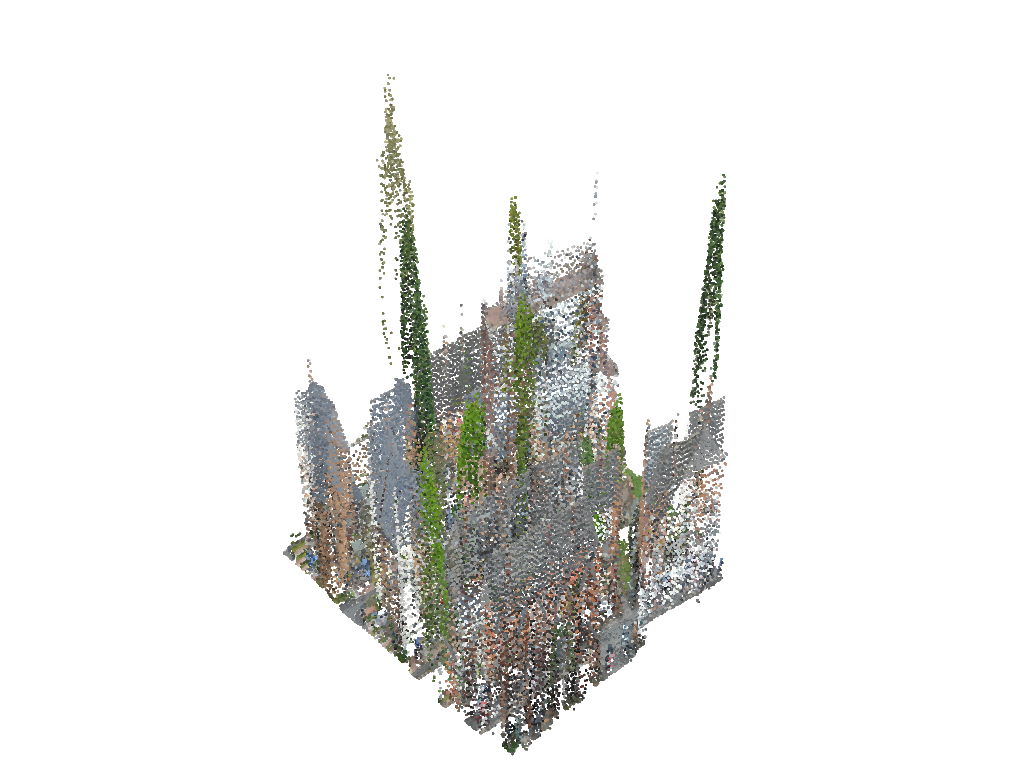

In [14]:
# Viz works better outside of notebook environment
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(point_cloud, point_size=3, render_points_as_spheres=True,
                 scalars='colors', lighting=False, rgb=True, preference='cell')
plotter.show()

In [22]:
print(x.min(), y.min(), z.min())
print(x.max(), y.max(), z.max())

-1.8498813 -1.7841264 -1.2134233
1.7035973 1.7610809 4.288898


In [15]:
classes_count = pd.DataFrame(pt.points['label']).value_counts().reset_index().set_index('label')

In [16]:
classes_df = pd.DataFrame.from_dict({'label': [1, 2, 3, 4, 5, 0], 'name': ['building', 'green area', 'car', 'ground', 'tree', 'road']}).set_index('label')
classes_df

,name
label,
1,building
2,green area
3,car
4,ground
5,tree
0,road


In [17]:
counts = classes_df.join(classes_count)

In [18]:
counts

,name,count
label,,
1,building,48377
2,green area,9617
3,car,1883
4,ground,24442
5,tree,8420
0,road,15113


In [19]:
torch.eye(3).repeat(2, 1, 1)

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])

In [20]:
# pool of size=3, stride=2
m = nn.MaxPool1d(3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)

In [174]:
output.shape

torch.Size([20, 16, 24])

In [175]:
import numpy as np
import torch.nn.functional as F
import pytorch_lightning as pl

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs, n, 3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool) # (bs, 1024)
      xb = F.relu(self.bn4(self.fc1(flat))) # (bs, 512)
      xb = F.relu(self.bn5(self.fc2(xb))) # (bs, 256)
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2) # why transpose?

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb) # global feature (bs, 1024, 1?)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64


class PointNet(pl.LightningModule):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return output, matrix3x3, matrix64x64
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        print(predictions.shape, y.shape, x.shape)
        loss = F.cross_entropy(predictions, y)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        loss = F.cross_entropy(predictions, y)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'val_loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        predicted_labels = torch.argmax(predictions, dim=-1)
        return predicted_labels

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

Steps

1. Dataset for reading a point cloud
2. ? Applying transformations like rotation? 
3. Subsampling point cloud 

In [176]:
class PointSampler:
    
    def __init__(self, subsample_size):
        self.subsample_size = subsample_size
    
    def __call__(self, point_cloud):
        indices = np.random.choice(point_cloud.index.values, size=self.subsample_size, replace=False)
        sampled_points = point_cloud.loc[indices]
        return sampled_points
    

class PointCloudSegmentationDataset(Dataset):
    
    def __init__(self, point_cloud_path, subsample_size, point_sampler):
        self.subsample_size = subsample_size
        self.point_sampler = point_sampler
        self.pt = PyntCloud.from_file(point_cloud_path)
        x = (self.pt.points['x'] - np.mean(self.pt.points['x'])) / np.std(self.pt.points['x'])
        y = (self.pt.points['y'] - np.mean(self.pt.points['y'])) / np.std(self.pt.points['y'])
        z = (self.pt.points['z'] - np.mean(self.pt.points['z'])) / np.std(self.pt.points['z'])
        
        self.pt.points['label'] = np.astype(pt.points['scalar_Classification'].values, int)
        self.pt.points['x_norm'] = x 
        self.pt.points['y_norm'] = y
        self.pt.points['z_norm'] = z 
        
    def __len__(self):
        return self.subsample_size
    
    def __getitem__(self, idx):
        sampled_cloud = self.point_sampler(self.pt.points[['x_norm', 'y_norm', 'z_norm', 'label']])
        sampled_points = torch.tensor(sampled_cloud[['x_norm', 'y_norm', 'z_norm']].values, device=device)
        labels = torch.tensor(sampled_cloud[['label']].values, device=device, dtype=torch.long).flatten()
        return sampled_points, labels
    

In [160]:
pt.points.loc[pt.points['label'] == 3, ['x']]

,x
57592,338.46875
57593,338.90625
57594,338.31250
57595,339.34375
57596,339.78125
...,...
59470,360.75000
59471,360.46875
59472,396.46875
59473,396.09375


In [193]:
class PointCloudClassificationDataset(Dataset):
    
    def __init__(self, point_cloud_path, subsample_size, point_sampler):
        self.subsample_size = subsample_size
        self.point_sampler = point_sampler
        self.pt = PyntCloud.from_file(point_cloud_path)
        x = (self.pt.points['x'] - np.mean(self.pt.points['x'])) / np.std(self.pt.points['x'])
        y = (self.pt.points['y'] - np.mean(self.pt.points['y'])) / np.std(self.pt.points['y'])
        z = (self.pt.points['z'] - np.mean(self.pt.points['z'])) / np.std(self.pt.points['z'])
        
        self.pt.points['label'] = np.astype(pt.points['scalar_Classification'].values, int)
        self.pt.points['x_norm'] = x 
        self.pt.points['y_norm'] = y
        self.pt.points['z_norm'] = z 
        
    def __len__(self):
        return self.subsample_size
    
    def __getitem__(self, idx):
        chosen_class = np.random.choice(len(self.pt.points['label'].unique()))
        sampled_cloud = self.point_sampler(self.pt.points.loc[self.pt.points['label'] == chosen_class, 
                ['x_norm', 'y_norm', 'z_norm']])
        sampled_points = torch.tensor(sampled_cloud[['x_norm', 'y_norm', 'z_norm']].values, device=device)
        label = torch.scalar_tensor(chosen_class, device=device, dtype=torch.long)
        return sampled_points.T, label 

In [194]:
np.random.choice(4)

2

In [195]:
subsample_size = 1024
training_dataset = PointCloudClassificationDataset('../data/birmingham_block_0/segmented-cloud-subsampled.ply', 
                                     subsample_size=subsample_size, point_sampler=PointSampler(subsample_size=subsample_size))

In [196]:
train_loader = DataLoader(training_dataset, batch_size=10, shuffle=True)

Each batch is a sampled point cloud

In [197]:
for row in train_loader:
    cloud, labels = row 
    batch = row
    print(cloud.shape)
    print(labels.shape)
    break

torch.Size([10, 3, 1024])
torch.Size([10])


In [198]:
model = PointNet(classes=6)

In [199]:
max_epochs = 10

trainer = pl.Trainer(max_epochs=max_epochs, fast_dev_run=True)

trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | transform | Transform   | 2.8 M  | train
1 | fc1       | Linear      | 524 K  | train
2 | fc2       | Linear      | 131 K  | train
3 | fc3       | Linear      | 1.5 K  | train
4 | bn1       | BatchNorm1d | 1.0 K  | train
5 | bn2       | BatchNorm1d | 512    | train
6 | dropout   | Dropout     | 0      | train
--------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5

Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([10, 6]) torch.Size([10]) torch.Size([10, 3, 1024])


`Trainer.fit` stopped: `max_steps=1` reached.
